In [1]:
import torch
from torchvision import models
from torchvision import transforms
import json
from torchvision.datasets.utils import download_url

from PIL import Image
import requests
from google.colab import files as FILE
#import os

def getImg(DownURL, path):
  img_data = requests.get(DownURL).content
  with open(path, 'wb') as handler:
    handler.write(img_data)

print(dir(models))

['AlexNet', 'DenseNet', 'EfficientNet', 'GoogLeNet', 'GoogLeNetOutputs', 'Inception3', 'InceptionOutputs', 'MNASNet', 'MobileNetV2', 'MobileNetV3', 'RegNet', 'ResNet', 'ShuffleNetV2', 'SqueezeNet', 'VGG', '_GoogLeNetOutputs', '_InceptionOutputs', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_utils', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'detection', 'efficientnet', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'feature_extraction', 'googlenet', 'inception', 'inception_v3', 'mnasnet', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mobilenetv2', 'mobilenetv3', 'quantization', 'regnet', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_80

In [ ]:
#alexnet = models.AlexNet()
resnet = models.resnet101(pretrained=True)
#print(resnet101)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std  = [0.229, 0.224, 0.225]
    )])
#print(preprocess)

In [ ]:
DownURL = 'https://media.istockphoto.com/photos/young-mother-taking-a-nap-with-her-babies-picture-id937289948?b=1&k=20&m=937289948&s=170667a&w=0&h=1KHehwwp02-LyD9MYyZ9MZRA5kvSC7QEzpWjUaQKOIU='
path='./dog.jpg'
getImg(DownURL, path)
img = Image.open("dog.jpg")

img_t = preprocess(img)
#print(img_t.shape)
batch_t = torch.unsqueeze(img_t, 0)
#print(batch_t.shape)

In [ ]:
resnet.eval()
out = resnet(batch_t)

In [ ]:
download_url("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", ".", "imagenet_class_index.json")

with open("imagenet_class_index.json", "r") as h:
    classes = json.load(h)

labels = []
for i in classes:
  labels.append(classes[str(i)])


Using downloaded and verified file: ./imagenet_class_index.json


In [ ]:
 _, index = torch.max(out,1)
percentage = torch.nn.functional.softmax(out,dim=1)[0] * 100
print(labels[index[0]], percentage[index[0]].item())

['n02101388', 'Brittany_spaniel'] 77.82074737548828


In [ ]:
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[(['n02101388', 'Brittany_spaniel'], 77.82074737548828),
 (['n02102177', 'Welsh_springer_spaniel'], 17.757923126220703),
 (['n02086646', 'Blenheim_spaniel'], 3.8902618885040283),
 (['n02100877', 'Irish_setter'], 0.11643564701080322),
 (['n02091244', 'Ibizan_hound'], 0.04309466853737831)]

**CycleGANS**

In [ ]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out
class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)


In [ ]:
netG = ResNetGenerator()

In [ ]:
import urllib.request
urllib.request.urlretrieve('https://github.com/deep-learning-with-pytorch/dlwpt-code/raw/master/data/p1ch2/horse2zebra_0.4.0.pth', 'horse2zebra_0.4.0.pth')

('horse2zebra_0.4.0.pth', <http.client.HTTPMessage at 0x7f5bc4071090>)

In [ ]:
model_path = './horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [ ]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [ ]:
preprocess = transforms.Compose([transforms.Resize(256),
transforms.ToTensor()])

In [ ]:
DownURL = 'https://images.unsplash.com/photo-1553284965-83fd3e82fa5a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2071&q=80'
path='./horse.jpeg'
getImg(DownURL, path)
img = Image.open("./horse.jpeg")

In [ ]:
#img

In [ ]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t,0)

In [ ]:
batch_out = netG(batch_t)

In [ ]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img.save('./zebra.jpg')

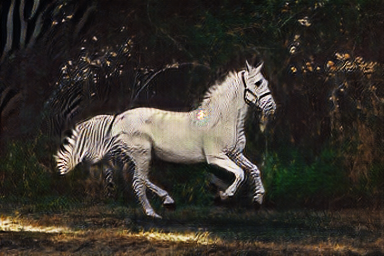

In [ ]:
out_img

In [ ]:
# from torch import hub
# resnet18_model = hub.load('pytorch/vision:main',
# 'resnet18',
# pretrained=True)